In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import warnings; warnings.simplefilter('ignore')

import os
import time
import scipy
import pandas as pd
import numpy as np

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score

import parallel
import evalutils

N_JOBS = 10
ORI_ID_USER = 'userId'
ORI_ID_ITEM = 'movieId'

SEQ_ID_USER = 'user_id'
SEQ_ID_ITEM = 'item_id'

SOURCE = os.path.expanduser("~/RecSys_Classification")

#Read Data
train = pd.read_hdf(
    os.path.join(SOURCE, 'data/train.hdf'))

test = pd.read_hdf(
    os.path.join(SOURCE, 'data/test.hdf'))

item_catalogue = pd.read_hdf(
    os.path.join(SOURCE, 'data/item_catalog.hdf'))

user_id_translator = pd.concat(
    [train, test], axis=0
).drop_duplicates([
    SEQ_ID_USER])[[ORI_ID_USER, SEQ_ID_USER]]
user_id_translator.sort_values(SEQ_ID_USER, inplace=True)

item_id_translator = pd.concat(
    [train, test], axis=0
).drop_duplicates([
    SEQ_ID_ITEM])[[ORI_ID_ITEM, SEQ_ID_ITEM]]
item_id_translator.sort_values(SEQ_ID_ITEM, inplace=True)

# Summary

In [2]:
userids = set(
    train[SEQ_ID_USER]
).union(
    test[SEQ_ID_USER])

itemids = set(
    train[SEQ_ID_ITEM]
).union(
    test[SEQ_ID_ITEM])

num_users = len(userids)
num_items = len(itemids)

print("num users: %s num items: %s (Transactions)" % (
    num_users, 
    num_items))

num users: 224959 num items: 7294 (Transactions)


## RecSys Train/Test Matrix and User/Item Feature Matrix

In [3]:
train_coo = scipy.sparse.coo_matrix(
        (
            np.ones(train.shape[0]),
            (train[SEQ_ID_USER], train[SEQ_ID_ITEM])
        ),
        shape=(num_users, num_items))
train_coo

<224959x7294 sparse matrix of type '<class 'numpy.float64'>'
	with 4940431 stored elements in COOrdinate format>

In [4]:
test_coo = scipy.sparse.coo_matrix(
        (
            np.ones(test.shape[0]),
            (test[SEQ_ID_USER], test[SEQ_ID_ITEM])
        ),
        shape=(num_users, num_items))
test_coo

<224959x7294 sparse matrix of type '<class 'numpy.float64'>'
	with 182583 stored elements in COOrdinate format>

# Train The RecSys Model

In [5]:
#EPOCHS ITERATIONS
EPOCHS_INCR = 1
EPOCHS = 8
iterations = range(
    EPOCHS_INCR, 
    EPOCHS + EPOCHS_INCR, 
    EPOCHS_INCR)

#Log Variables (Train/Test)
train_auc = []
test_auc = []
train_sample_ids = train.sample(1000)[SEQ_ID_USER].unique()

#Train Model
model = LightFM(learning_rate=0.05, loss='warp')
for epoch in iterations:
    print("[epoch: %s]" % epoch)
    start_time = time.time()

    model.fit_partial(
        train_coo, 
        epochs=EPOCHS_INCR,
        num_threads=N_JOBS)
    
    train_auc_local = auc_score(
        model,
        train_coo,
        num_threads=N_JOBS).mean()
    train_auc.append(train_auc_local)
    
    test_auc_local = auc_score(
        model,
        test_coo,
        num_threads=N_JOBS).mean()
    test_auc.append(test_auc_local)
    
    print('\tTrain AUC: %s.5' % train_auc_local)
    print('\tTest AUC: %s.5' % test_auc_local)
    
    print("Elapsed Time: %smin" % round(
        (time.time() - start_time)/60, 2))

[epoch: 1]
	Train AUC: 0.963538.5
	Test AUC: 0.88543326.5
Elapsed Time: 0.36min
[epoch: 2]
	Train AUC: 0.9701632.5
	Test AUC: 0.88367015.5
Elapsed Time: 0.37min
[epoch: 3]
	Train AUC: 0.9736003.5
	Test AUC: 0.8819009.5
Elapsed Time: 0.38min
[epoch: 4]
	Train AUC: 0.97580147.5
	Test AUC: 0.8802982.5
Elapsed Time: 0.37min
[epoch: 5]
	Train AUC: 0.97734237.5
	Test AUC: 0.87939525.5
Elapsed Time: 0.38min
[epoch: 6]
	Train AUC: 0.9785153.5
	Test AUC: 0.87948555.5
Elapsed Time: 0.38min
[epoch: 7]
	Train AUC: 0.979454.5
	Test AUC: 0.87940484.5
Elapsed Time: 0.36min
[epoch: 8]
	Train AUC: 0.9802119.5
	Test AUC: 0.87891674.5
Elapsed Time: 0.37min


# Train Precision / Test Precision

In [6]:
def sample_recommendation(model, data_coo, id_user, top_k=10):
    
    local_train = train[train[SEQ_ID_USER] == id_user]
    
    genres = {}
    for x in item_catalogue.loc[local_train[SEQ_ID_ITEM]]['genres']:
        for y in x:
            if y in genres:
                genres[y] += 1
            else:
                genres[y] = 1
        
    genres = pd.Series(genres).sort_values(ascending=False)
    genres = ((genres / local_train.shape[0]).round(2) * 100).astype(int)
    genres = genres.to_dict()
    genres = ["%s:%s" %(genre, genre_cnt) for genre, genre_cnt in genres.items()]
    genres = "|".join(genres)
    
    #genres = local_train['genres'].value_counts() / local_train.shape[0]
    print("Items in train", local_train.shape, genres)
    
    known_positives = data_coo.tocsr()[id_user].indices
    known_positives = item_catalogue.loc[known_positives]
    
    scores = model.predict(
        id_user, 
        np.arange(num_items))
    
    ranking = np.argsort(-scores)
    
    top_items = item_catalogue.loc[ranking[:top_k]]

    print("User %s" % id_user)

    known_positives.index = ['Known Positives'] * known_positives.shape[0]
    top_items.index = ['Recommended'] * top_items.shape[0]
    
    print(pd.concat([known_positives, top_items])[[
        'title', 'genres', 'year'
    ]])

for it in range(2):
    print("------\nExample %s\n--------" % it)
    sample_recommendation(
        model=model,
        data_coo=test_coo,
        id_user=test.sample(1)[SEQ_ID_USER].values[0])

------
Example 0
--------
Items in train (0, 8) 
User 16955
                                                             title  \
Known Positives                                      The Vanishing   
Known Positives                                      New York Doll   
Known Positives                             Adventures of Zatôichi   
Known Positives                     The Woman with the 5 Elephants   
Known Positives                                  Dog Day Afternoon   
Known Positives                                           Hot Fuzz   
Known Positives                                       The Guardian   
Known Positives                                   A Bridge Too Far   
Known Positives                                            In Time   
Known Positives                                    Horrible Bosses   
Known Positives                                     High and Dizzy   
Known Positives                                    The Tooth Fairy   
Known Positives               

# GB

In [20]:
#Get embeddings from RecSys Model
item_emb = pd.DataFrame(model.item_embeddings)
item_emb = item_emb.add_prefix("i_latent_")

user_emb = pd.DataFrame(model.user_embeddings)
user_emb = user_emb.add_prefix("u_latent_")

#Join all items and get unique SEQ_ID, ORI_ID pairs
ui_trans = pd.concat([train, test], axis=0)

user_ids = ui_trans[[SEQ_ID_USER, ORI_ID_USER]].drop_duplicates()
item_ids = ui_trans[[SEQ_ID_ITEM, ORI_ID_ITEM]].drop_duplicates()

#user/item embeddings original IDs
user_emb[ORI_ID_USER] = user_ids[ORI_ID_USER].values
item_emb[ORI_ID_ITEM] = item_ids[ORI_ID_ITEM].values

#Set IDs as index
user_emb.set_index(ORI_ID_USER, inplace=True)
item_emb.set_index(ORI_ID_ITEM, inplace=True)

In [21]:
"""
For the classification task we will merely use 
the user embedding obtained from the RecSys model
in order to predict the movie genre a user will
watch.
"""

#Get candidates for the task
candidates_classification = test.sort_values(
    'timestamp', 
    ascending=True
).drop_duplicates(
    SEQ_ID_USER, 
    keep='first')

In [22]:
#Split Train/Test
train_portion = .8
n = candidates_classification.shape[0]
train_size = int(n * train_portion)

candidates_classification.reset_index(inplace=True)
X_train_ids = candidates_classification.sample(train_size)
X_test_ids = candidates_classification[~candidates_classification.index.isin(X_train_ids.index)]

X_train_ids = X_train_ids[[SEQ_ID_ITEM, ORI_ID_USER]]
X_test_ids = X_test_ids[[SEQ_ID_ITEM, ORI_ID_USER]]

In [23]:
#Order embeddings according to train/test respectively
X_train = user_emb.loc[X_train_ids[ORI_ID_USER]]
X_test = user_emb.loc[X_test_ids[ORI_ID_USER]]

#Get genres of train/test respectively
item_catalogue.index = item_catalogue[SEQ_ID_ITEM]

y_train = item_catalogue.loc[X_train_ids[SEQ_ID_ITEM]]['genres']
y_test = item_catalogue.loc[X_test_ids[SEQ_ID_ITEM]]['genres']

In [24]:
all_genres = set([])
for genres in y_train:
    all_genres.update(genres)
genres_to_num = dict([(c, it) for it, c in enumerate(all_genres)])

def get_one_genre(x):
    if not isinstance(x, list):
        return "OTHER"
    elif len(x) > 0:
        return genres_to_num[x[0]]
    else:
        return len(all_genres)

y_train = y_train.apply(get_one_genre)
y_test = y_test.apply(get_one_genre)

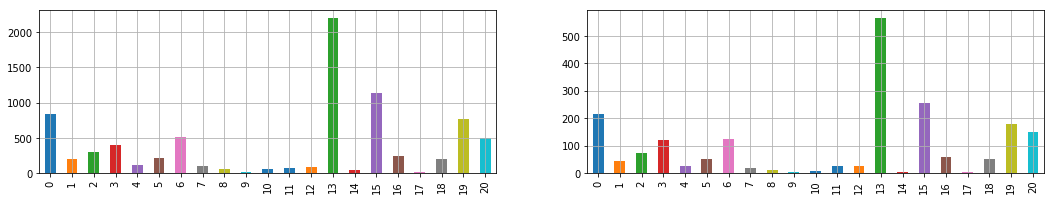

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(18, 3))
(y_train.value_counts()).sort_index().plot(kind='bar', grid=True, ax=ax[0])
(y_test.value_counts()).sort_index().plot(kind='bar', grid=True, ax=ax[1])

# XGB Simple

In [31]:
import xgboost as xgb
import evalutils

cls = xgb.XGBClassifier(n_jobs=8, n_estimators=500)
cls.fit(X_train.values, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=8, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

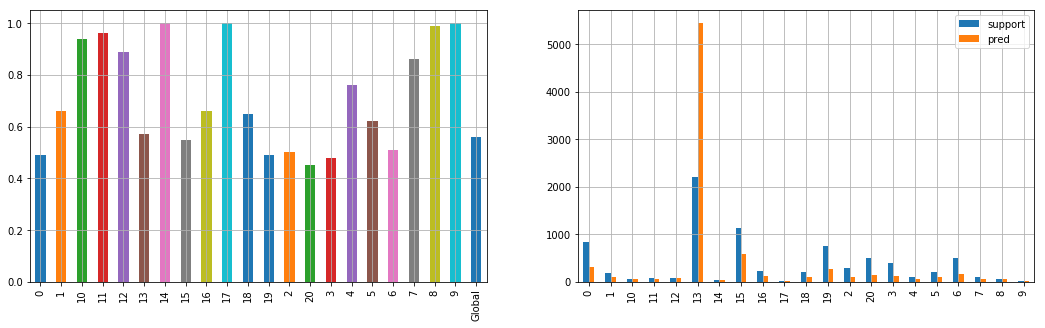

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
train_report = evalutils.class_report(
    y_true=y_train,
    y_pred=cls.predict(X_train.values))

train_report['f1-score'].plot(kind='bar', grid=True, ax=ax[0])
train_report.drop('Global')[['support', 'pred']].plot(kind='bar', grid=True, ax=ax[1])

fig.set_size_inches(18, 5)

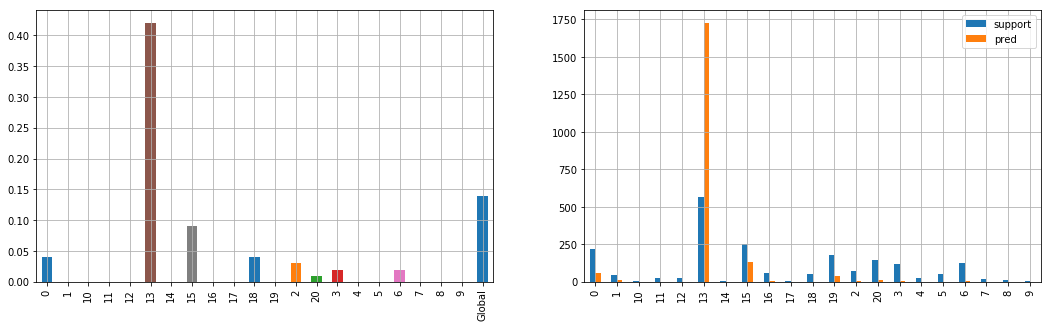

In [33]:
fig, ax = plt.subplots(1, 2)
test_report = evalutils.class_report(
    y_true=y_test,
    y_pred=cls.predict(X_test.values))

test_report['f1-score'].plot(kind='bar', grid=True, ax=ax[0])
test_report.drop('Global')[['support', 'pred']].plot(kind='bar', grid=True, ax=ax[1])

fig.set_size_inches(18, 5)

# XGB Binary

In [37]:
import sys; sys.path.append("/home/ubuntu/XGB-BINARY/")
from XGBBinary import XGBBinary

cls_bin = XGBBinary(gridsearch={})
cls_bin.fit(X_train.values, y_train)

Classifier label 0
----Best model---
-----------------
          y  precision  recall  f1-score  support    pred
0         0       0.90    0.69      0.78   3607.0  2793.0
1         1       0.10    0.31      0.16    421.0  1235.0
Global  all       0.81    0.65      0.72   4028.0  4028.0
-----------------------------
Classifier label 1
----Best model---
-----------------
          y  precision  recall  f1-score  support    pred
0         0       0.98    0.89      0.93   3940.0  3580.0
1         1       0.03    0.15      0.05     88.0   448.0
Global  all       0.96    0.87      0.91   4028.0  4028.0
-----------------------------
Classifier label 2
----Best model---
-----------------
          y  precision  recall  f1-score  support    pred
0         0       0.96    0.84      0.90   3870.0  3384.0
1         1       0.04    0.18      0.07    158.0   644.0
Global  all       0.93    0.81      0.86   4028.0  4028.0
-----------------------------
Classifier label 3
----Best model---
------------

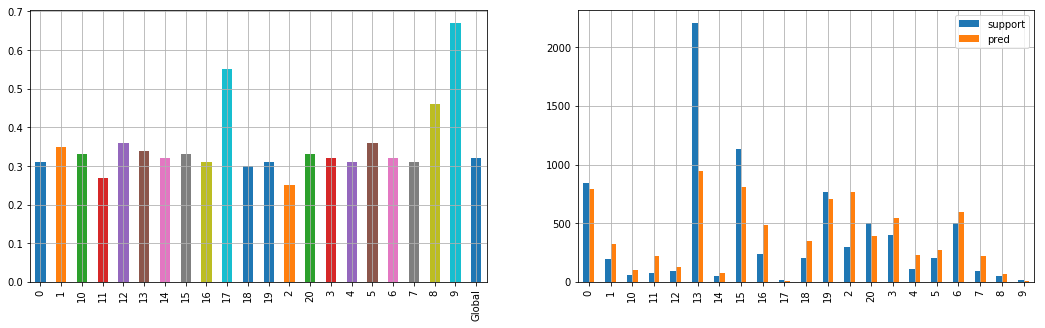

In [35]:
fig, ax = plt.subplots(1, 2)
train_report = evalutils.class_report(
    y_true=y_train,
    y_pred=cls_bin.predict(X_train.values))

train_report['f1-score'].plot(kind='bar', grid=True, ax=ax[0])
train_report.drop('Global')[['support', 'pred']].plot(kind='bar', grid=True, ax=ax[1])

fig.set_size_inches(18, 5)

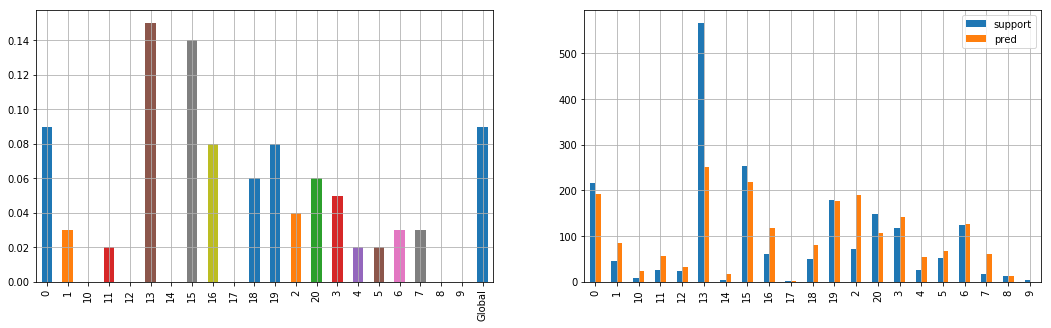

In [36]:
fig, ax = plt.subplots(1, 2)
test_report = evalutils.class_report(
    y_true=y_test,
    y_pred=cls_bin.predict(X_test.values))

test_report['f1-score'].plot(kind='bar', grid=True, ax=ax[0])
test_report.drop('Global')[['support', 'pred']].plot(kind='bar', grid=True, ax=ax[1])

fig.set_size_inches(18, 5)